In [31]:
# 3D CNN Model
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
from collections import Counter
import os
import torch.nn.functional as F
import pandas as pd
from TrackAtoms import match_atoms_to_pdb
from Bio.PDB import PDBParser
import re

# 3D CNN Model
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        
        self.conv0 = nn.Conv3d(in_channels=37, out_channels=64, kernel_size=1, stride=1, padding=0) # play around with output channels
        self.conv1 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

        #self.dropout_conv = nn.Dropout3d(p=0.05)
        
        # After two pooling layers, spatial dimensions reduce from 40x40x40 -> 5x5x5
        self.fc1 = nn.Linear(128 * 3 * 3 * 3, 256)  # Try increasing over 256
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Assuming 1 output for docking status/position

        #self.dropout_fc = nn.Dropout(p=0.15)
        
    def forward(self, x):
        # Forward pass through Conv layers
        x = self.pool(torch.relu(self.conv0(x)))  # Conv0 -> ReLU -> Pooling
        #x = self.dropout_conv(x)
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool2(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling

        # Flatten the input for fully connected layers
        x = x.view(-1, 128 * 3 * 3 * 3)
        
        # Forward pass through fully connected layers
        x = torch.relu(self.fc1(x)) #use tanh activation
        #x = self.dropout_fc(x)
        x = torch.relu(self.fc2(x))
        x = torch.nn.functional.softmax(self.fc3(x), dim=1)  # Final layer (output layer)
        #x = torch.clamp(x, min=1e-7, max=1 - 1e-7)  # Clamp outputs to avoid extreme values
        
        return x

In [32]:
def get_atom_info_from_pdb(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("mol", pdb_file)
    atoms = []

    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    if atom.is_disordered():
                        for alt_atom in atom.disordered_get_list():
                            atoms.append(alt_atom)
                    else:
                        atoms.append(atom)

    return atoms

def natural_sort_key(s):
    """Function to sort strings in a natural alphanumeric order."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

GradCam

Atom Importance for 50 models

In [33]:
# === Grad-CAM for 3D CNN ===
class GradCAM3D:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        
        self.gradients = None
        self.activations = None

        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_full_backward_hook(backward_hook))  # updated

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot)

        grads = self.gradients[0]  # (C, D, H, W)
        activations = self.activations[0]  # (C, D, H, W)

        weights = torch.mean(grads.view(grads.size(0), -1), dim=1)
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = F.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.cpu().numpy()

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

subtype_counts_per_exp = []
residue_counts_per_exp = []

In [34]:
def save_counters_to_csv(counter_list, out_csv):
    """
    Save a list[Counter] (one Counter per experiment) to a single CSV where
    rows = experiments and columns = labels (missing labels filled with 0).
    """
    # Union of all labels across experiments
    all_labels = sorted(set().union(*[set(c.keys()) for c in counter_list])) if counter_list else []
    rows = []
    for i, c in enumerate(counter_list, start=1):
        row = {lbl: int(c.get(lbl, 0)) for lbl in all_labels}
        row["__experiment__"] = i
        rows.append(row)
    df = pd.DataFrame(rows).set_index("__experiment__")
    df.to_csv(out_csv, index=True)

def load_counters_from_csv(csv_path):
    """
    Load the CSV saved by save_counters_to_csv back into a list[Counter],
    one Counter per experiment (row). Works with plot_mean_std() unchanged.
    """
    df = pd.read_csv(csv_path, index_col="__experiment__")
    # Ensure ints (in case CSV round-trips as floats)
    df = df.fillna(0)
    if not df.empty:
        df = df.astype(int)
    counters = []
    for _, row in df.iterrows():
        # Only keep nonzero entries to keep Counters clean
        c = Counter({col: int(val) for col, val in row.items() if int(val) != 0})
        counters.append(c)
    return counters

In [35]:
# # preload models
# all_models = []

# models_exp1 = []
# model_paths = sorted(glob.glob("../../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp1/Models/*.pth"), key=natural_sort_key)
# for mp in model_paths:
#     m = CNN3D()
#     m.load_state_dict(torch.load(mp, weights_only=True))
#     # Create GradCAM with CPU model (hooks bind by object, device can change later)
#     gc = GradCAM3D(m, m.conv2)  # adjust layer if needed
#     models_exp1.append((m, gc))
# all_models.append(models_exp1)

# models_exp2 = []
# model_paths = sorted(glob.glob("../../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp2/Models/*.pth"), key=natural_sort_key)
# for mp in model_paths:
#     m = CNN3D()
#     m.load_state_dict(torch.load(mp, weights_only=True))
#     # Create GradCAM with CPU model (hooks bind by object, device can change later)
#     gc = GradCAM3D(m, m.conv2)  # adjust layer if needed
#     models_exp2.append((m, gc))
# all_models.append(models_exp2)

# models_exp3 = []
# model_paths = sorted(glob.glob("../../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp3/Models/*.pth"), key=natural_sort_key)
# for mp in model_paths:
#     m = CNN3D()
#     m.load_state_dict(torch.load(mp, weights_only=True))
#     # Create GradCAM with CPU model (hooks bind by object, device can change later)
#     gc = GradCAM3D(m, m.conv2)  # adjust layer if needed
#     models_exp3.append((m, gc))
# all_models.append(models_exp3)

# models_exp4 = []
# model_paths = sorted(glob.glob("../../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp4/Models/*.pth"), key=natural_sort_key)
# for mp in model_paths:
#     m = CNN3D()
#     m.load_state_dict(torch.load(mp, weights_only=True))
#     # Create GradCAM with CPU model (hooks bind by object, device can change later)
#     gc = GradCAM3D(m, m.conv2)  # adjust layer if needed
#     models_exp4.append((m, gc))
# all_models.append(models_exp4)

# models_exp5 = []
# model_paths = sorted(glob.glob("../../../Models/Cholesterol/3DCNN/3DCholesterolModels-st_exp5/Models/*.pth"), key=natural_sort_key)
# for mp in model_paths:
#     m = CNN3D()
#     m.load_state_dict(torch.load(mp, weights_only=True))
#     # Create GradCAM with CPU model (hooks bind by object, device can change later)
#     gc = GradCAM3D(m, m.conv2)  # adjust layer if needed
#     models_exp5.append((m, gc))
# all_models.append(models_exp5)

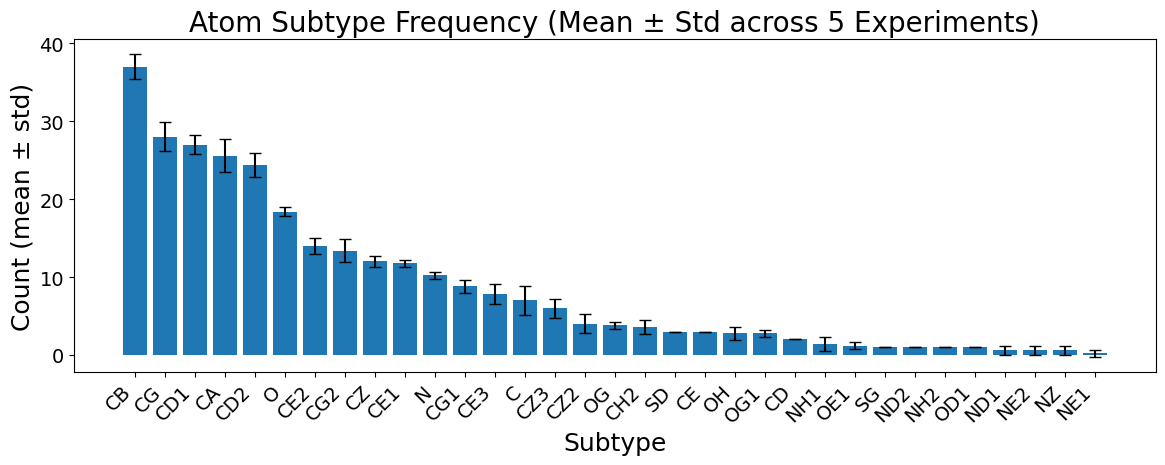

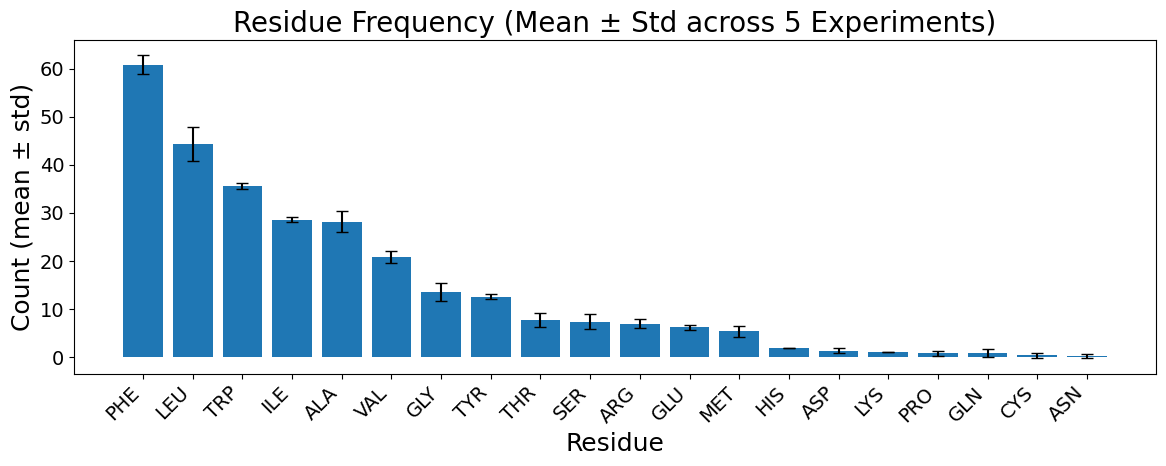

In [36]:
# for exp_index, experiment_models in enumerate(all_models):
#     print(exp_index, "is experiment index")

#     subtype_counts = Counter()
#     residue_counts = Counter()

#     #positive_grids = glob.glob(f"../../../Data/SplitData/Cholesterol/cholesterol-grid-st_exp{exp_index + 1}/Test/Positive/*.npy")
#     positive_grids = glob.glob(f"../../../Data/SplitData/Cholesterol/IvanTestSet/ivan-grid-st/positive/*.npy")

#     for index, grid_path in enumerate(positive_grids):
#         if index % 10 == 0:
#             print("Progress:", index, "/", "57")

#         # === Load Input ===
#         input_tensor = np.load(grid_path)  # (30, 30, 30, 23)
#         input_tensor = torch.from_numpy(input_tensor).float().permute(3, 0, 1, 2).unsqueeze(0)  # (1, 23, 30, 30, 30)

#         all_feature_scores = []
#         cam_sum = np.zeros((30, 30, 30), dtype=np.float32)

#         for model, gradcam in experiment_models:
#             cam = gradcam.generate_cam(input_tensor)  # (D', H', W')
            
#             # Resize CAM to input size
#             cam_tensor = torch.tensor(cam).unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)
#             cam_resized = F.interpolate(cam_tensor, size=(30, 30, 30), mode='trilinear', align_corners=False)
#             cam_resized = cam_resized.squeeze().cpu().numpy()

#             cam_sum += cam_resized

#         threshold = 0.0

#         # === Average the CAMs ===
#         cam_avg = cam_sum / len(experiment_models)

#         input_grid = input_tensor.squeeze().cpu().numpy()  # shape: (23, 30, 30, 30)

#         # After computing cam_avg
#         coords = np.argwhere(cam_avg >= threshold)   # <- use cam_avg here

#         # Iterate over coordinates and check if corresponding voxel has any non-zero channel
#         valid_coords = []
#         for coord in coords:
#             x, y, z = coord
#             voxel_values = input_grid[:, x, y, z]  # (23,)
#             if np.any(voxel_values != 0):
#                 valid_coords.append((x, y, z))

#         data = []

#         # print(f"Number of valid gridpoints with score >= {threshold} and non-zero voxel: {len(valid_coords)}")
#         # print("\nGrad-CAM scores for valid coordinates:")
#         for coord in valid_coords:
#             x, y, z = coord
#             score = cam_avg[x, y, z]
#             #print(f"Coord (x={x}, y={y}, z={z}) -> Grad-CAM score: {score:.4f}")
#             data.append({'x': x, 'y': y, 'z': z, 'score': score})

#         df = pd.DataFrame(data)

#         # Sort by score in descending order (most important first)
#         df_sorted = df.sort_values(by='score', ascending=False)

#         basename = os.path.basename(grid_path)
#         protein_name = basename[:4]

#         #pdb_file = f"../3DCNN/filtered-pdbs-distinct-5A/positive/{protein_name}-filtered.pdb"
#         pdb_file = f"../GNN/ivan-pdbs-distinct-5A/positive/{protein_name}-filtered.pdb"

#         grid = np.load(grid_path)

#         mapped_atoms = match_atoms_to_pdb(grid, pdb_file, df_sorted)

#         atoms_info = get_atom_info_from_pdb(pdb_file) # lookup atom subtype from atom id

#         #print(mapped_atoms[:5])

#         for atom_info in mapped_atoms[:5]:
#             atom_id = atom_info['atom_id'] - 1

#             if atom_id < len(atoms_info):
#                 atom = atoms_info[atom_id]
#                 subtype = atom.get_name()                     # e.g. 'CB'
#                 residue = atom.get_parent().get_resname()     # e.g. 'LEU'
#                 #print(f"Atom {atom_id + 1}: Subtype = {subtype}, Residue = {residue}")

#                 subtype_counts[subtype] += 1
#                 residue_counts[residue] += 1            
#             else:
#                 raise Exception(f"Invalid atom_id: {atom_id}")

#         # # === Visualize the average CAM ===
#         # mid = cam_avg.shape[0] // 2
#         # plt.imshow(cam_avg[mid], cmap='jet')
#         # plt.title(f'Average Grad-CAM (Z={mid}) over {len(models_path)} models')
#         # plt.colorbar()
#         # plt.show()

#     for _, gradcam in experiment_models:
#         gradcam.remove_hooks()
    
#     subtype_counts_per_exp.append(subtype_counts)
#     residue_counts_per_exp.append(residue_counts)

def plot_mean_std(counter_list, title, xlabel):
    # union of all labels
    labels = sorted(set().union(*[set(c.keys()) for c in counter_list]))
    # build matrix E x L (experiments x labels)
    M = np.array([[c.get(lbl, 0) for lbl in labels] for c in counter_list], dtype=float)
    means = M.mean(axis=0)
    stds  = M.std(axis=0, ddof=1) if M.shape[0] > 1 else np.zeros_like(means)

    # sort indices by mean (descending)
    sorted_idx = np.argsort(means)[::-1]
    labels = [labels[i] for i in sorted_idx]
    means = means[sorted_idx]
    stds  = stds[sorted_idx]

    # plot
    x = np.arange(len(labels))
    plt.rcParams.update({"font.size": 18})  # increase global font size
    plt.figure(figsize=(12,5))              # smaller horizontal size
    plt.bar(x, means, yerr=stds, capsize=4)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel("Count (mean ± std)", fontsize=18)
    plt.tight_layout()
    plt.show()

# save_counters_to_csv(subtype_counts_per_exp, "subtype_counts_per_exp_internal_cnn_ivan_st.csv")
# save_counters_to_csv(residue_counts_per_exp, "residue_counts_per_exp_internal_cnn_ivan_st.csv")

subtype_counts_per_exp = load_counters_from_csv("CSV\'s/subtype_counts_per_exp_internal_cnn_ivan_st.csv")
residue_counts_per_exp = load_counters_from_csv("CSV\'s/residue_counts_per_exp_ivan_cnn.csv")

plot_mean_std(subtype_counts_per_exp, "Atom Subtype Frequency (Mean ± Std across 5 Experiments)", "Subtype")
plot_mean_std(residue_counts_per_exp, "Residue Frequency (Mean ± Std across 5 Experiments)", "Residue")


In [37]:
def save_feature_scores(all_feature_scores, mean_tensor, std_tensor,
                        per_exp_csv="all_feature_scores_per_exp.csv",
                        summary_csv="all_feature_scores_summary.csv",
                        feature_labels=None):
    """
    Save per-experiment feature scores and the final mean/std summary to CSVs.
    - all_feature_scores: list of torch tensors (per experiment, shape=(23,))
    - mean_tensor: torch tensor shape (23,)
    - std_tensor:  torch tensor shape (23,)
    """
    # Per-experiment matrix
    per_exp_data = torch.stack(all_feature_scores, dim=0).cpu().numpy()
    df_exp = pd.DataFrame(per_exp_data, columns=feature_labels)
    df_exp.index.name = "experiment"
    df_exp.to_csv(per_exp_csv)

    # Summary (mean ± std)
    df_summary = pd.DataFrame({
        "feature": feature_labels,
        "mean": mean_tensor.cpu().numpy(),
        "std": std_tensor.cpu().numpy()
    })
    df_summary.to_csv(summary_csv, index=False)
    print(f"Saved {per_exp_csv} and {summary_csv}")


def load_feature_scores(per_exp_csv="all_feature_scores_per_exp.csv",
                        summary_csv="all_feature_scores_summary.csv"):
    """
    Reload per-experiment feature scores and summary.
    Returns (all_feature_scores, mean_tensor, std_tensor, feature_labels).
    """
    # Per-experiment
    df_exp = pd.read_csv(per_exp_csv, index_col="experiment")
    feature_labels = df_exp.columns.tolist()
    all_feature_scores = [torch.tensor(row.values, dtype=torch.float32)
                          for _, row in df_exp.iterrows()]

    # Summary
    df_summary = pd.read_csv(summary_csv)
    mean_tensor = torch.tensor(df_summary["mean"].values, dtype=torch.float32)
    std_tensor  = torch.tensor(df_summary["std"].values, dtype=torch.float32)

    return all_feature_scores, mean_tensor, std_tensor, feature_labels

Feature_importance

In [38]:
# # === Load Input ===

# input_files = glob.glob("../../../Data/SplitData/Cholesterol/IvanTestSet/ivan-grid-st/positive/*.npy")
# all_feature_scores = []

# for exp_index, experiment_models in enumerate(all_models):
#     #input_files = glob.glob(f"../../../Data/SplitData/Cholesterol/cholesterol-grid-st_exp{exp_index + 1}/Test/Positive/*.npy")
#     experiment_feature_scores = []
#     for index, file_path in enumerate(input_files):
#         if index % 10 == 0:
#             print(f"{index}/{len(input_files)}")
        
#         input_tensor = np.load(file_path)  # (30, 30, 30, 23)
#         input_tensor = torch.from_numpy(input_tensor).float().permute(3, 0, 1, 2).unsqueeze(0)  # (1, 23, 30, 30, 30)
        
#         for model, gc in experiment_models:
#             device = next(model.parameters()).device
#             x = input_tensor.to(device)

#             # --- Grad-CAM heatmap for this input & model ---
#             # enable grads because Grad-CAM does a backward pass internally
#             with torch.enable_grad():
#                 cam_np = gc.generate_cam(x, target_class=None)  # shape: (D_cam, H_cam, W_cam), values ~ [0,1]
#             cam = torch.from_numpy(cam_np).to(device).float()

#             # --- Resize CAM to match input spatial size if needed ---
#             D, H, W = x.shape[2], x.shape[3], x.shape[4]
#             if cam.shape != (D, H, W):
#                 cam = F.interpolate(
#                     cam.unsqueeze(0).unsqueeze(0),  # (1,1,Dc,Hc,Wc)
#                     size=(D, H, W),
#                     mode="trilinear",
#                     align_corners=False
#                 ).squeeze(0).squeeze(0)

#             # Safety re-normalization (keeps CAM in [0,1], avoids degenerate cases)
#             cam_min = cam.min()
#             cam_max = cam.max()
#             if (cam_max - cam_min) > 1e-8:
#                 cam = (cam - cam_min) / (cam_max - cam_min)
#             else:
#                 cam = torch.zeros_like(cam)

#             # --- Per-feature importance using CAM as a spatial weight ---
#             # x: (1, C, D, H, W), cam: (D, H, W)
#             # broadcast cam over channels and batch
#             weighted = (x[0] * cam.unsqueeze(0))  # (C, D, H, W)
#             feature_scores = weighted.abs().mean(dim=(1, 2, 3))  # (C,)

#             experiment_feature_scores.append(feature_scores.detach().cpu())

#     # === Average across 50 models ===
#     print(len(experiment_feature_scores[0]))
#     feature_scores_stack = torch.stack(experiment_feature_scores)  #
#     feature_scores_mean = feature_scores_stack.sum(dim=0)  # 
#     all_feature_scores.append(feature_scores_mean)

# # === Mean & Std across the 5 experiments ===
# F = torch.stack(all_feature_scores, dim=0)            # (E,23)
# all_feature_scores_mean = F.mean(dim=0)               # (23,)
# all_feature_scores_std  = F.std(dim=0, unbiased=True) # (23,)

# # === Optional: Top-k important features ===
# topk = torch.topk(feature_scores_mean, k=5)
# print("\nTop 5 Important Features:")
# for i, (idx, val) in enumerate(zip(topk.indices.tolist(), topk.values.tolist()), 1):
#     print(f"{i}. Feature {idx} → Importance Score")

In [39]:
#feature_scores_mean

feature_labels = [
    'C', 'CA', 'CB', 'CD', 'CD1', 'CD2', 'CE', 'CE1', 'CE2', 'CE3',
    'CG', 'CG1', 'CG2', 'CH2', 'CZ', 'CZ2', 'CZ3',

    # Oxygen (O) subtypes
    'O', 'OH', 'OD1', 'OD2', 'OE1', 'OE2', 'OG', 'OG1',

    # Nitrogen (N) subtypes
    'N', 'NE', 'NE1', 'NE2', 'ND1', 'ND2', 'NZ', 'NH1', 'NH2',

    # Sulfur (S) subtypes
    'SD', 'SG', 'OXT'
]

# save_feature_scores(
#     all_feature_scores,
#     all_feature_scores_mean,
#     all_feature_scores_std,
#     per_exp_csv="all_feature_scores_per_exp_internal_cnn_st.csv",
#     summary_csv="all_feature_scores_summary_internal_cnn_st.csv",
#     feature_labels=feature_labels
# )

all_feature_scores, all_feature_scores_mean, all_feature_scores_std, feature_labels = \
    load_feature_scores("all_feature_scores_per_exp_internal_cnn_ivan_gradcam_st.csv", "all_feature_scores_summary_internal_cnn_ivan_gradcam_st.csv")

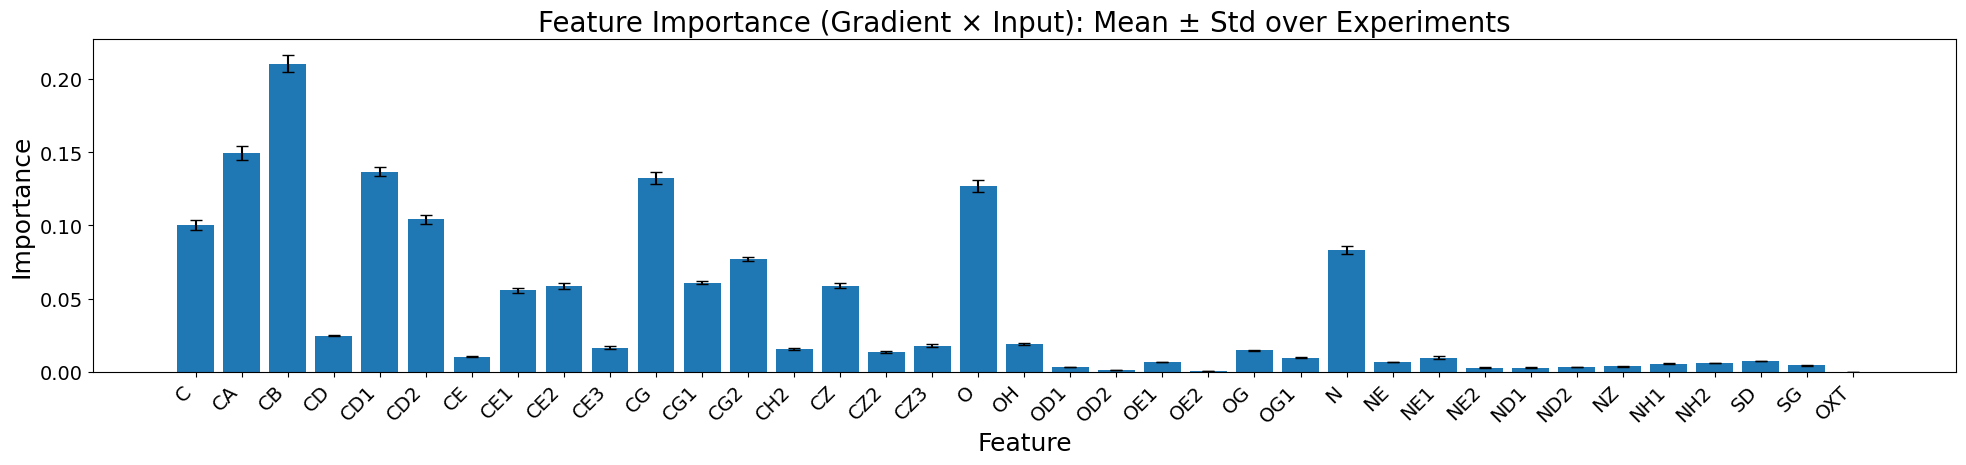

In [40]:
# === Plot mean ± std, sorted greatest → least ===
means_np = all_feature_scores_mean.cpu().numpy()
stds_np  = all_feature_scores_std.cpu().numpy()

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 18})   # larger fonts globally
plt.figure(figsize=(20, 5))              # smaller horizontal size

x = np.arange(len(feature_labels))
plt.bar(x, means_np, yerr=stds_np, capsize=4)

plt.xticks(x, feature_labels, rotation=45, ha='right')
plt.xlabel("Feature", fontsize=18)
plt.ylabel("Importance", fontsize=18)
plt.title("Feature Importance (Gradient × Input): Mean ± Std over Experiments", fontsize=20)

plt.tight_layout()
plt.show()

['C', 'CA', 'CB', 'CD', 'CD1', 'CD2', 'CE', 'CE1', 'CE2', 'CE3', 'CG', 'CG1', 'CG2', 'CH2', 'CZ', 'CZ2', 'CZ3', 'N', 'ND1', 'ND2', 'NE', 'NE1', 'NE2', 'NH1', 'NH2', 'NZ', 'O', 'OD1', 'OD2', 'OE1', 'OE2', 'OG', 'OG1', 'OH', 'SD', 'SG']


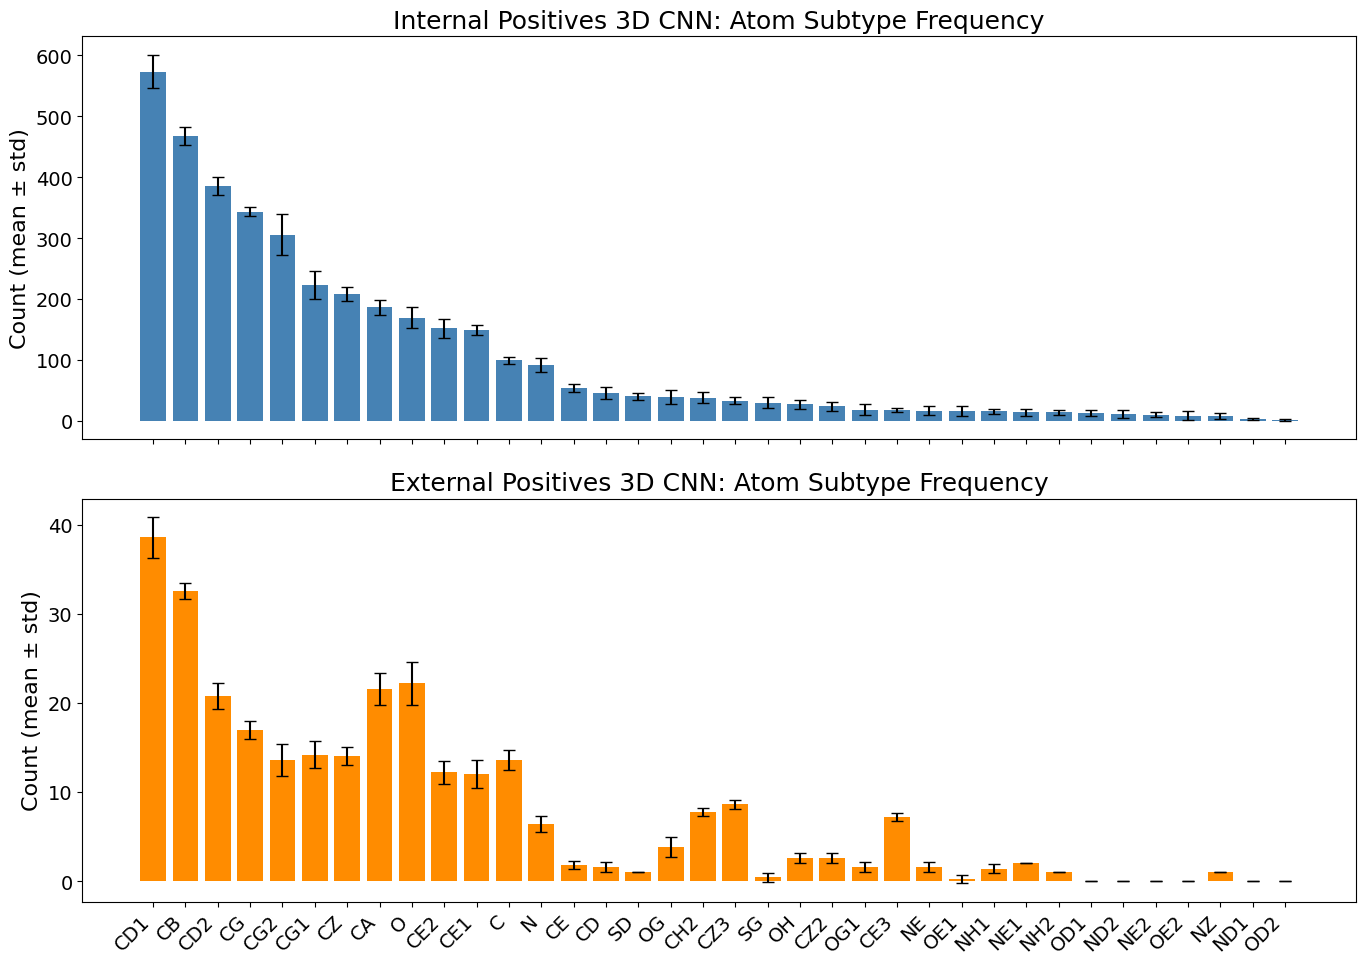

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load data ===
csv1 = pd.read_csv("CSV\'s/subtype_counts_per_exp.csv")
csv2 = pd.read_csv("CSV\'s/subtype_counts_per_exp_ivan_cnn.csv")

# Drop experiment column
csv1 = csv1.drop(columns="__experiment__")
csv2 = csv2.drop(columns="__experiment__")

# Union of all subtypes
all_labels = sorted(set(csv1.columns).union(set(csv2.columns)))

print(all_labels)

# Reindex to have same columns, fill missing with 0
csv1 = csv1.reindex(columns=all_labels, fill_value=0)
csv2 = csv2.reindex(columns=all_labels, fill_value=0)

# === Compute mean ± std ===
means1 = csv1.mean(axis=0)
stds1  = csv1.std(axis=0, ddof=1)

means2 = csv2.mean(axis=0)
stds2  = csv2.std(axis=0, ddof=1)

# Sort labels by descending mean of dataset 1
sorted_idx = np.argsort(means1.values)[::-1]
sorted_labels = [all_labels[i] for i in sorted_idx]

means1 = means1[sorted_labels]
stds1  = stds1[sorted_labels]
means2 = means2[sorted_labels]
stds2  = stds2[sorted_labels]

x = np.arange(len(sorted_labels))

# === Plot stacked vertically (shared x-axis) ===
fig, axes = plt.subplots(2, 1, figsize=(14,10), sharex=True)

# Dataset 1
axes[0].bar(x, means1, yerr=stds1, capsize=4, color="steelblue")
axes[0].set_ylabel("Count (mean ± std)")
axes[0].set_title("Internal Positives 3D CNN: Atom Subtype Frequency")

# Dataset 2
axes[1].bar(x, means2, yerr=stds2, capsize=4, color="darkorange")
axes[1].set_ylabel("Count (mean ± std)")
axes[1].set_title("External Positives 3D CNN: Atom Subtype Frequency")

# Shared x-axis labels
axes[1].set_xticks(x)
axes[1].set_xticklabels(sorted_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

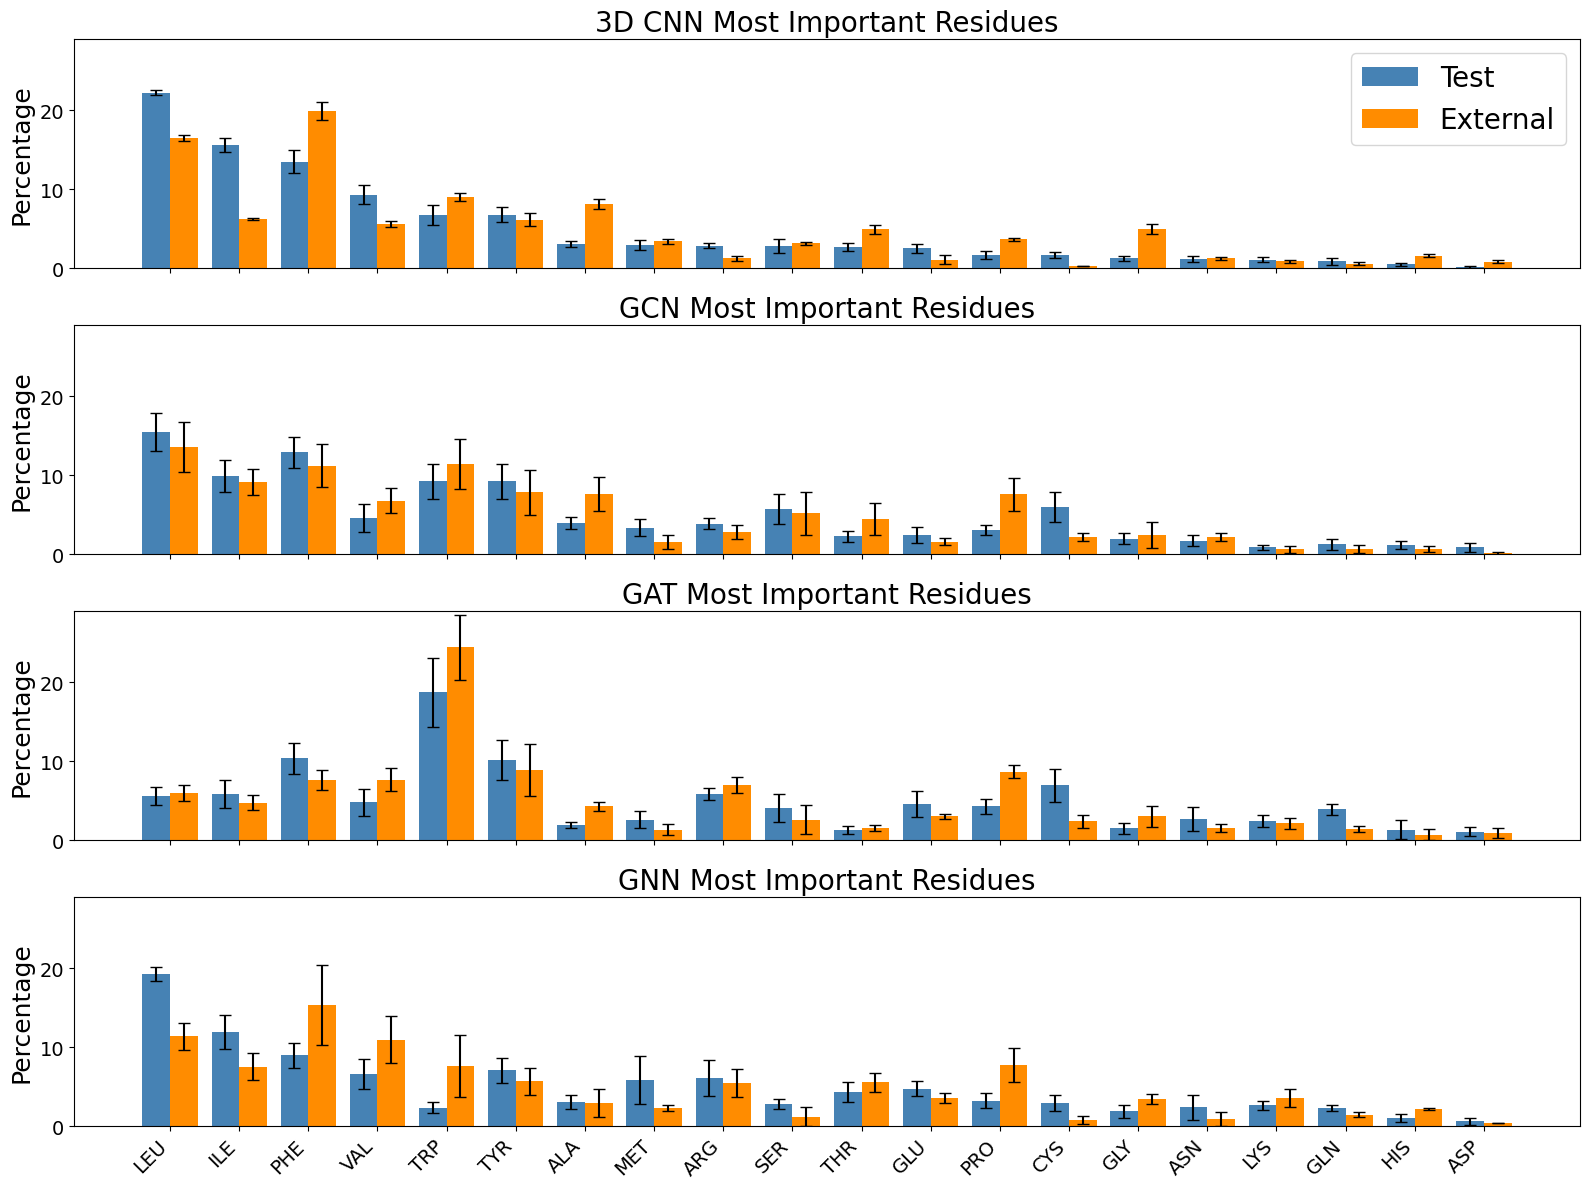

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG: point these to your six CSVs ----------
# Each CSV should look like your existing files: one row per experiment,
# columns are residue labels; includes a "__experiment__" column to drop.
paths = {
    ("3D CNN", "Test"): "CSV\'s/residue_counts_per_exp_internal_cnn_st.csv",
    ("3D CNN", "External"): "CSV\'s/residue_counts_per_exp_internal_cnn_ivan_st.csv",
    ("GCN",    "Test"): "CSV\'s/gcn_internal_residue_counts_per_exp.csv",
    ("GCN",    "External"): "CSV\'s/gcn_external_residue_counts_per_exp.csv",
    ("GAT",    "Test"): "CSV\'s/gat_internal_residue_counts_per_exp.csv",
    ("GAT",    "External"): "CSV\'s/gat_external_residue_counts_per_exp.csv",
    ("GNN",    "Test"): "/home/alexhernandez/transmembranebindingAI/Notebooks/Cholesterol/CaseEvaluation/gnn_out_internal/cross_experiment/top_residues_topk_frequency_counts_by_experiment.csv",
    ("GNN",    "External"): "/home/alexhernandez/transmembranebindingAI/Notebooks/Cholesterol/CaseEvaluation/gnn_out_external/cross_experiment/top_residues_topk_frequency_counts_by_experiment.csv"    
}

plt.rcParams.update({
    "axes.titlesize": 18,    # panel titles
    "axes.labelsize": 16,    # axis labels
    "xtick.labelsize": 14,   # x tick labels
    "ytick.labelsize": 14,   # y tick labels
    "legend.fontsize": 20,   # legend (if added later)
    "figure.titlesize": 20   # global figure title (if used)
})

# Optional: set this to True to plot percentages instead of raw counts
NORMALIZE_TO_PERCENT = True

# ---------- helpers ----------
def load_counts_df(path):
    df = pd.read_csv(path)
    if "__experiment__" in df.columns:
        df = df.drop(columns="__experiment__")
    return df

def means_stds(df):
    # mean/std across experiments for each label (column)
    m = df.mean(axis=0)
    s = df.std(axis=0, ddof=1) if df.shape[0] > 1 else pd.Series(0.0, index=df.columns)
    return m, s

# ---------- 1) Load all, build union of labels ----------
dfs = {}
for key, p in paths.items():
    df = load_counts_df(p)
    dfs[key] = df

all_labels = sorted(set().union(*[set(df.columns) for df in dfs.values()]))

# ---------- 2) Reindex all to union & (optionally) normalize ----------
for key, df in dfs.items():
    df = df.reindex(columns=all_labels, fill_value=0)
    if NORMALIZE_TO_PERCENT:
        row_sums = df.sum(axis=1).replace(0, np.nan)
        df = df.div(row_sums, axis=0).fillna(0) * 100.0
    dfs[key] = df

# ---------- 3) Compute means/stds ----------
stats = {}
for key, df in dfs.items():
    m, s = means_stds(df)
    stats[key] = (m, s)

# ---------- 4) Choose a reference order for x-axis (descending mean) ----------
ref_key = list(paths.keys())[0]  # first item in 'paths' dict (3D CNN, Internal by default)
ref_means = stats[ref_key][0]
sorted_labels = list(ref_means.sort_values(ascending=False).index)

# ---------- 5) Plot: 3 rows (models) × 1 col (Internal + External combined) ----------
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
model_order = ["3D CNN", "GCN", "GAT", "GNN"]
colors = {"Test": "steelblue", "External": "darkorange"}

# --- Compute global y-axis limit across all means+stds ---
global_max = max((m + s).max() for (m, s) in stats.values())

bar_width = 0.4  # width of each bar (Internal / External)

for r, model in enumerate(model_order):
    ax = axes[r]
    key_int = (model, "Test")
    key_ext = (model, "External")

    if key_int not in stats or key_ext not in stats:
        ax.set_axis_off()
        ax.set_title(f"{model} (missing data)")
        continue

    means_int, stds_int = stats[key_int]
    means_ext, stds_ext = stats[key_ext]

    means_int = means_int[sorted_labels]
    stds_int  = stds_int[sorted_labels]
    means_ext = means_ext[sorted_labels]
    stds_ext  = stds_ext[sorted_labels]

    x = np.arange(len(sorted_labels))
    
    # Internal (shifted left)
    ax.bar(x - bar_width/2, means_int.values, yerr=stds_int.values,
           capsize=4, width=bar_width, color=colors["Test"], label="Test")

    # External (shifted right)
    ax.bar(x + bar_width/2, means_ext.values, yerr=stds_ext.values,
           capsize=4, width=bar_width, color=colors["External"], label="External")

    # Titles, limits
    ax.set_title((f"{model} Most Important Residues"), fontsize=20)
    ax.set_ylim(0, global_max + 0.5)

    # Y label only on left side
    ylabel = "Percentage" if NORMALIZE_TO_PERCENT else "Count (mean ± std)"
    ax.set_ylabel(ylabel, fontsize=18)

    # X ticks only on bottom
    if r == len(model_order) - 1:
        ax.set_xticks(x)
        ax.set_xticklabels(sorted_labels, rotation=45, ha='right', fontsize=14)
    else:
        ax.set_xticks([])

    # Add legend
    if r == 0:
        ax.legend()

plt.tight_layout()
plt.show()




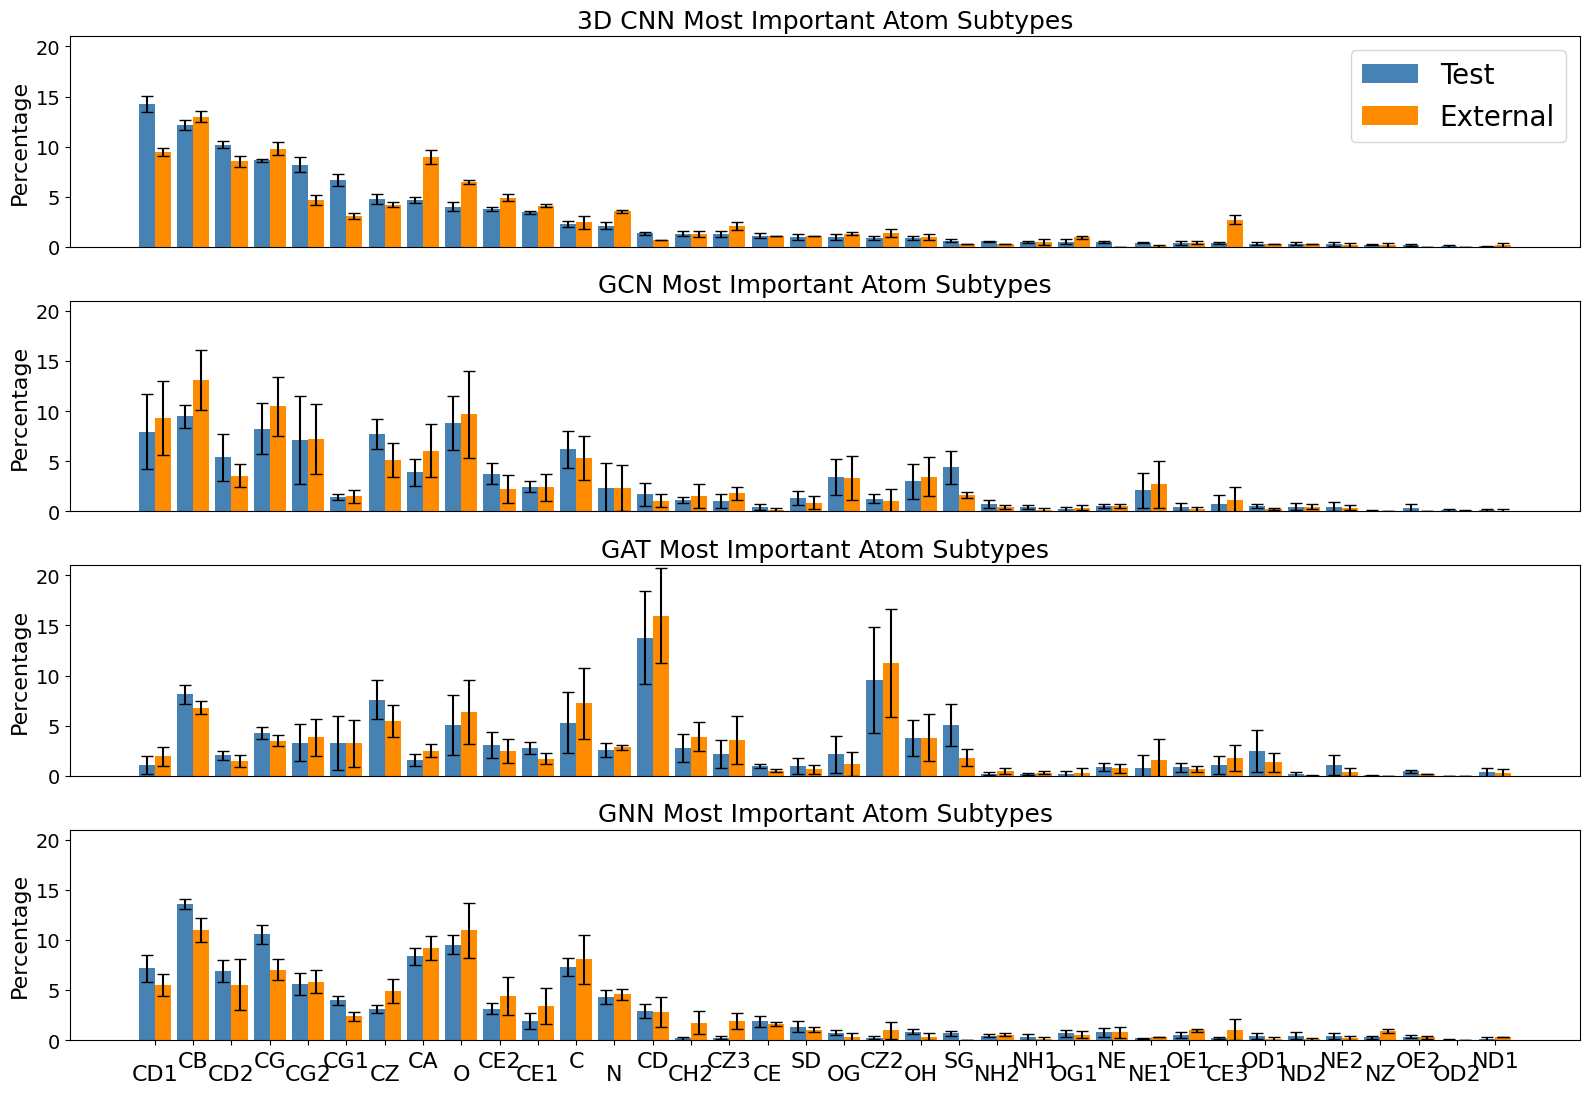

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
NORMALIZE_TO_PERCENT = True
X_TICK_FONTSIZE = 16
X_TICK_ODD_OFFSET  = -0.03   # odd-index labels slightly closer to axis
X_TICK_EVEN_OFFSET = -0.09   # even-index labels slightly lower
Y_MAX_OVERRIDE = None        # set to a number (e.g., 21.0) to force max; else auto (100 if %)

# >>> Font config (bigger everywhere except x-axis ticks) <<<
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,
    "figure.titlesize": 20,
    "xtick.labelsize": X_TICK_FONTSIZE
})

paths = {
    ("3D CNN", "Test"): "CSV\'s/subtype_counts_per_exp_internal_cnn_st.csv",
    ("3D CNN", "External"): "CSV\'s/subtype_counts_per_exp_internal_cnn_ivan_st.csv",
    ("GCN",    "Test"): "CSV's/gcn_internal_atom_counts_per_exp.csv",
    ("GCN",    "External"): "CSV's/gcn_external_atom_counts_per_exp.csv",
    ("GAT",    "Test"): "CSV's/gat_internal_atom_counts_per_exp.csv",
    ("GAT",    "External"): "CSV's/gat_external_atom_counts_per_exp.csv",
    ("GNN",    "Test"): "/home/alexhernandez/transmembranebindingAI/Notebooks/Cholesterol/CaseEvaluation/gnn_out_internal/cross_experiment/top_subtypes_topk_frequency_counts_by_experiment.csv",
    ("GNN",    "External"): "/home/alexhernandez/transmembranebindingAI/Notebooks/Cholesterol/CaseEvaluation/gnn_out_external/cross_experiment/top_subtypes_topk_frequency_counts_by_experiment.csv" 
}

colors = {"Test": "steelblue", "External": "darkorange"}

def load_counts_df(path):
    df = pd.read_csv(path)
    if "__experiment__" in df.columns:
        df = df.drop(columns="__experiment__")
    return df

def means_stds(df):
    m = df.mean(axis=0)
    s = df.std(axis=0, ddof=1) if df.shape[0] > 1 else pd.Series(0.0, index=df.columns)
    return m, s

def set_staggered_bottom_xticklabels(ax, labels, fontsize=12,
                                     odd_offset=-0.03, even_offset=-0.09):
    x = np.arange(len(labels))
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0, ha='center', fontsize=fontsize)
    ax.tick_params(axis='x', bottom=True, labelbottom=True, top=False, labeltop=False, pad=0)
    for i, tick in enumerate(ax.xaxis.get_majorticklabels()):
        tick.set_y(odd_offset if (i % 2 == 1) else even_offset)  # odd above, even below

def nice_upper_bound(value, base=5.0):
    return base * np.ceil(value / base) if value > 0 else base

# ---------- Load ----------
dfs = {k: load_counts_df(p) for k, p in paths.items()}
all_labels = sorted(set().union(*[set(df.columns) for df in dfs.values()]))

# Reindex + normalize (optional)
for k, df in dfs.items():
    df = df.reindex(columns=all_labels, fill_value=0)
    if NORMALIZE_TO_PERCENT:
        row_sums = df.sum(axis=1).replace(0, np.nan)
        df = df.div(row_sums, axis=0).fillna(0) * 100.0
    dfs[k] = df

# Stats
stats = {k: means_stds(df) for k, df in dfs.items()}

# Reference order (descending by first dataset's means)
ref_key = list(paths.keys())[0]
ref_means = stats[ref_key][0]
sorted_labels = list(ref_means.sort_values(ascending=False).index)

# ---------- Global y-limit ----------
if NORMALIZE_TO_PERCENT:
    y_upper = 21.0
else:
    global_max = 0.0
    for (model, split), (m, s) in stats.items():
        if len(m) == 0: 
            continue
        panel_max = (m + s).max()
        if np.isfinite(panel_max):
            global_max = max(global_max, float(panel_max))
    y_upper = nice_upper_bound(global_max * 1.05, base=5.0)
    if Y_MAX_OVERRIDE is not None:
        y_upper = Y_MAX_OVERRIDE

# ---------- Plot: 3 rows (models) × 1 col (combined Int/Ext per model) ----------
model_order = ["3D CNN", "GCN", "GAT", "GNN"]
fig, axes = plt.subplots(len(model_order), 1, figsize=(16, 12), sharex=True, sharey=True)
if len(model_order) == 1:
    axes = [axes]

for r, model in enumerate(model_order):
    ax = axes[r]

    # Gather Internal / External if present
    groups = []
    for split in ["Test", "External"]:
        key = (model, split)
        if key in stats:
            means, stds = stats[key]
            groups.append((split, means[sorted_labels], stds[sorted_labels]))

    if not groups:
        ax.set_axis_off()
        ax.set_title(f"{model} – (no data)")
        continue

    x = np.arange(len(sorted_labels))

    # Bar positions and widths
    if len(groups) == 2:
        width = 0.42
        offsets = [-width/2, +width/2]
    else:
        width = 0.7
        offsets = [0.0]

    bars_for_legend = []
    for (offset, (split, means, stds)) in zip(offsets, groups):
        b = ax.bar(x + offset, means.values, yerr=stds.values, capsize=4,
                   width=width, color=colors.get(split, None), label=split)
        bars_for_legend.append(b)

    ax.set_title(f"{model} Most Important Atom Subtypes")
    ax.set_ylim(0, y_upper)
    ax.set_ylabel("Percentage" if NORMALIZE_TO_PERCENT else "Count (mean ± std)")

    # Legend (only if both Internal & External present)
    if r == 0 and len(groups) >= 2:
        ax.legend(loc="upper right", frameon=True)

    # Bottom row: staggered x labels
    if r == len(model_order) - 1:
        set_staggered_bottom_xticklabels(
            ax, sorted_labels,
            fontsize=X_TICK_FONTSIZE,
            odd_offset=X_TICK_ODD_OFFSET,
            even_offset=X_TICK_EVEN_OFFSET
        )
    else:
        ax.set_xticks([])
        ax.tick_params(axis='x', bottom=False, labelbottom=False, top=False, labeltop=False)

plt.tight_layout(rect=[0, 0.06, 1, 0.98])
plt.show()
